## Neural Network model
input data <- 조업편차분석
<br>input size <- (53, 7596)
<br>output data <- 'A10' feature

In [2]:
#import libraries
import numpy as np

#for loss graph visualization only
import matplotlib.pyplot as plt

In [3]:
# upload data file
file_dir = '조업편차분석.txt'

In [4]:
# opening 조업편차분석 데이터
with open(file_dir, 'r') as f:
    input_data = [x.strip().split(' ')[1:] for x in f.readlines()]
    f.close()

In [5]:
input_data = np.array(input_data[1:])
np.shape(input_data)

(7596, 54)

In [6]:
# separate x and y (독립변수 / 종속변수('A10'))
y = input_data[:, 9].astype('float')
x = np.delete(input_data, np.s_[9:10], axis = 1).astype('float')

np.shape(x), np.shape(y)

((7596, 53), (7596,))

In [7]:
# train test split 7:3
def train_test_split(x, y, ratio=0.7):
    split_idx = int(len(x)*ratio)
    trainX = x[:split_idx]
    trainy = y[:split_idx]

    testX = x[split_idx:]
    testy = y[split_idx:]

    return trainX, testX, trainy, testy

### Define necessary functions
- Normalization
- Activation functions
- Initialize parameters
- Feedforward
- Backpropagation
- weight update

In [8]:
def Standard(X):
    X_scaled = ( X - X.mean(axis=0) ) / X.std(axis=0)
    return X_scaled, X.mean(axis=0), X.std(axis=0)

def de_Standard(X_scaled, mean, std):
    X = ( X_scaled * std ) + mean
    return X

In [9]:
# sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [10]:
# initialize parameters
def initialize_parameters(input_size, hidden_size, output_size):
    #np.random.seed(0)
    # hidden layers
    W1 = np.random.randn(hidden_size, input_size) * 0.01
    b1 = np.zeros((hidden_size, 1))

    #output layer
    W2 = np.random.randn(output_size, hidden_size)
    b2 = np.zeros((output_size, 1))

    parameters = [W1, b1, W2, b2]

    return parameters

In [11]:
# Feedforward
def forward_propagation(input_data, parameters):
    # retrieve the parameters
    W1, b1, W2, b2 = parameters
    
    # compute the activation of the hidden layer
    Z1 = np.dot(W1, input_data.T) + b1
    A1 = sigmoid(Z1)
    
    # compute the activation of the output layer
    Z2 = np.dot(W2, A1) + b2
    A2 = Z2 #sigmoid(Z2) ## linear
    
    cache = [Z1, A1, Z2, A2]
    
    return A2, cache

- dA2 shape: (1, 5317)
- dZ2 shape: (1, 5317)
- dW2 shape: (1, 3)
- db2 shape: (1, 1)
- dA1 shape: (3, 5317)
- dZ1 shape: (3, 5317)
- dW1 shape: (3, 53)
- db1 shape: (3, 1)

In [12]:
# Backpropagation
def backpropagation(parameters, cache, X, y):
    m = y.shape[0] # number of input data

    # retrieve the intermediate values
    Z1, A1, Z2, A2 = cache

    # compute the derivative of the loss with respect to A2
    # dA2 =  - (y/A2) + ((1-y)/(1-A2)) # derivative of binary cross entropy loss function
    dA2 = A2 - y # derivative of MSE loss function

    # compute the derivative of the activation function of the output layer
    dZ2 = dA2  #* (A2 * (1-A2)) # derivative of sigmoid activation function

    # compute the derivative of the weights and biases of the output layer
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    #=========

    # compute the derivative of the activation function of the hidden layer
    dA1 = np.dot(parameters[2].T, dZ2) #parameters[2] == W2  
    dZ1 = dA1 * (A1 * (1-A1)) 

    # compute the derivative of the weights and biases of the hidden layer
    dW1 = (1/m) * np.dot(dZ1, X)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    gradients = [dW1, db1, dW2, db2]

    return gradients
    

In [13]:
# update parameters
def update_parameters(parameters, gradients, learning_rate):
    # retrieve the gradients
    dW1, db1, dW2, db2 = gradients
    
    # retrieve the weights and biases
    W1, b1, W2, b2 = parameters
    
    # update the weights and biases
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    
    parameters = [W1, b1, W2, b2]
    
    return parameters

In [14]:
# MSE loss function
def MSE(y_pred, y_true):
    total_error = np.sum((y_pred - y_true)**2)
    return total_error / len(y_true)

# MAE loss function
def MAE(y_pred, y_true):
    total_error = np.sum(np.abs(y_pred - y_true))
    return total_error / len(y_true)

In [41]:
# accuracy calculation
# https://www.ncl.ac.uk/webtemplate/ask-assets/external/maths-resources/statistics/regression-and-correlation/coefficient-of-determination-r-squared.html
def r_squared(y_pred, y_true):
    ssr = np.sum((y_pred-y_true)**2)
    sst = np.sum((y_true.mean()-y_true)**2)
    return 1- (ssr/sst)

## Total model layout

In [42]:
# data preprocessing
x_scaled, X_mean, X_std = Standard(x)
y_scaled, y_mean, y_std = Standard(y)
trainX, testX, trainy, testy = train_test_split(x_scaled, y_scaled)
print(f'train set of input data:\t{trainX.shape}\ntest set of input data:\t\t{testX.shape}')
trainy.shape, testy.shape

train set of input data:	(5317, 53)
test set of input data:		(2279, 53)


((5317,), (2279,))

In [43]:
# hyperparameter settings
learning_rate = 0.01
epochs = 500

In [44]:
# training
mse = []
rs = []
mae = []
input_size = trainX.shape[1]
hidden_size = 10
output_size = 1
parameters = initialize_parameters(input_size, hidden_size, output_size)

for epoch in range(epochs):
    A2, cache = forward_propagation(trainX, parameters)

    # calculate loss
    loss = MSE(A2, trainy)
    loss_2 = MAE(A2, trainy)
    acc = r_squared(A2, trainy)
    mse.append(loss)
    mae.append(loss_2)
    rs.append(acc)

    gradients = backpropagation(parameters, cache, trainX, trainy)
    parameters = update_parameters(parameters, gradients, learning_rate)

    if epoch % 100 == 0:
        print(f'MSE for epoch # {epoch+1} : {loss}')

MSE for epoch # 1 : 1.3794159301959488
MSE for epoch # 101 : 0.3245899602375765
MSE for epoch # 201 : 0.23780655289051467
MSE for epoch # 301 : 0.19678753584745104
MSE for epoch # 401 : 0.17275239957737443


In [45]:
A2.shape

(1, 5317)

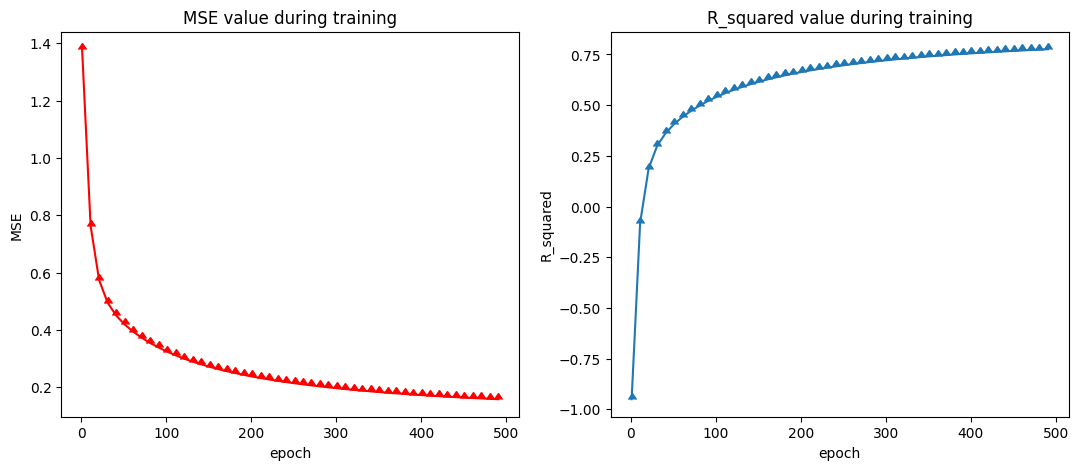

R-square	:	0.7776815048789896
RMAE		:	0.39655138863816536
MAE		:	0.15725300383085725


In [46]:
# visualize loss graph
visual_pts = 10

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.plot(np.arange(1,len(mse)+1, visual_pts), mse[::visual_pts], marker=10, color = 'r')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.title('MSE value during training')

plt.subplot(1,2,2)
plt.plot(np.arange(1,len(rs)+1, visual_pts), rs[::visual_pts], marker=10)
plt.xlabel('epoch')
plt.ylabel('R_squared')
plt.title('R_squared value during training')
plt.show()

print(f'R-square\t:\t{rs[np.argmax(rs)]}\nRMAE\t\t:\t{np.sqrt(mse[np.argmin(mse)])}\nMAE\t\t:\t{mse[np.argmin(mae)]}')

In [47]:
# testing
# retrieve the  parameters
tW1, tb1, tW2, tb2 = parameters

# compute the activation of the hidden layer
tZ1 = np.dot(tW1, x_scaled.T) + tb1
tA1 = sigmoid(tZ1)

# compute the activation of the output layer
tZ2 = np.dot(tW2, tA1) + tb2
tA2 = tZ2 #sigmoid(tZ2)

tloss = MSE(tA2, y_scaled)

unscaled_y_true = de_Standard(y_scaled, y_mean, y_std)
unscaled_y_pred = de_Standard(tA2, y_mean, y_std)
# r_squared(unscaled_y_pred[0][:4000], unscaled_y_true[:4000])

print(f'MSE for test dataset : {tloss}')

MSE for test dataset : 0.5491295766053449


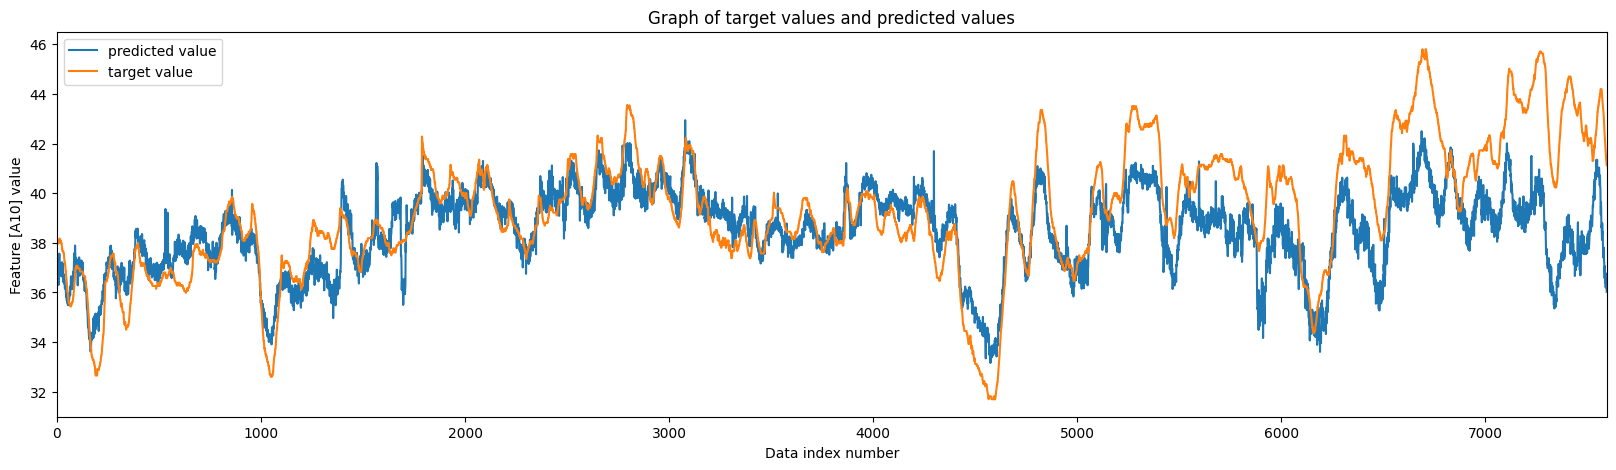

In [48]:
# visualization of model output values and the target values
plt.figure(figsize=(20,5))
plt.xlabel('Data index number')
plt.ylabel('Feature [A10] value')
plt.title('Graph of target values and predicted values')
plt.plot(unscaled_y_pred[0], label = 'predicted value')
plt.plot(unscaled_y_true, label = 'target value')
plt.xlim([0, len(unscaled_y_true)])
plt.legend()
plt.show()